## Retraining 'eye_tracking' model for subject and predicting eye track (pixel coordinate).

In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from sklearn.utils import shuffle
from joblib import load as j_load
from joblib import dump as j_dump
import time
import os

In [2]:
# Parameters
path2root = "../../"
models_fol = "models/"
models_et_fol = "et/"
trained_fol = "trained/"
subjects_dir = "subjects/"
data_et_fol = "data-et-clb/"
sbj_scalers_boi_fol = "scalers-boi.bin"
sbj_model_boi_fol = "model-boi"
sbj_num = 24
sbj_num_test = 25
model_num = 5
r_train = 0.85
n_epochs = 40
patience = 5
trainable_layers = 2
chosen_inputs = [0, 1, 2, 6, 7, 8, 9]
y_scale = 1000.0

In [3]:
sbj_dir = path2root + subjects_dir + f"{sbj_num}/"
trained_dir = path2root + models_fol + models_et_fol + trained_fol

### Retraining 'eye_tracking' model with subject calibration data

In [4]:
data_et_dir = sbj_dir + data_et_fol
print(f"\nLoading subject data in {data_et_dir}")
with open(data_et_dir + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(data_et_dir + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(data_et_dir + "y.pickle", "rb") as f:
    y_load = pickle.load(f)
n_smp, frame_h, frame_w = x1_load.shape[:-1]
print(f"Samples number: {n_smp}")


Loading subject data in ../../subjects/24/data-et-clb/
Samples number: 4200


In [5]:
import matplotlib.pyplot as plt

[ 2.92193524  0.12354425 -0.86240532 -1.57755936  5.01365275 70.57027415
  0.51105064  0.5061323   0.46361178  0.46345159]
[0.00530988 0.016     ]


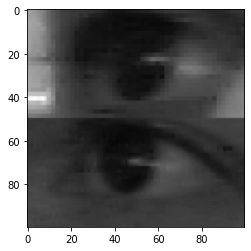

In [6]:
# Displaying data
smp_num = 2
print(x2_load[smp_num])
print(y_load[smp_num])
plt.imshow(x1_load[smp_num].reshape((frame_h, frame_w)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

#### Getting those data that looking 'in' screen

In [7]:
# print("\nNormalizing data...")
# sbj_scalers_boi_dir = sbj_dir + sbj_scalers_boi_fol
# x2_chs_inp = x2_load[:, chosen_inputs]
# x1_scaler_boi, x2_scaler_boi = j_load(sbj_scalers_boi_dir)
# x1_boi = x1_load / x1_scaler_boi
# x2_boi = x2_scaler_boi.transform(x2_chs_inp)

In [8]:
# print("\nLoading in_blink_out model...")
# sbj_model_boi_dir = sbj_dir + sbj_model_boi_fol
# model_boi = load_model(sbj_model_boi_dir)
# print(model_boi.summary())

In [9]:
# print("\nPredicting those data that looking 'in' screen.")
# yhat_boi = model_boi.predict([x1_boi, x2_boi]).argmax(1)

In [10]:
# # Choosing those data
# x1_new = []
# x2_new = []
# y_new = []
# for (x10, x20, y0, yht0) in zip(x1_load, x2_load, y_load, yhat_boi):
#     if True: # yht0 != 1:
#         x1_new.append(x10)
#         x2_new.append(x20)
#         y_new.append(y0)

# x1_new = np.array(x1_new)
# x2_new = np.array(x2_new)
# y_new = np.array(y_new)
# n_smp_new = x1_new.shape[0]
# print(f"New samples: {n_smp_new}")

### Preparing modified calibration data to feeding in eye_tracking model

In [11]:
print("\nNormalizing modified calibration data to feeding in eye_tracking model...")
public_scalers_dir = trained_dir + "scalers.bin"
scalers = j_load(public_scalers_dir)
x1_scaler, x2_scaler = scalers

x2_chs_inp = x2_load[:, chosen_inputs]

x1_nrm = x1_load / x1_scaler
x2_nrm = x2_scaler.transform(x2_chs_inp)

j_dump(scalers, sbj_dir + "scalers.bin")


Normalizing modified calibration data to feeding in eye_tracking model...


F:\Education_Study\University\MSC\Thesis\EyeTracker\venv\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


['../../subjects/24/scalers.bin']

In [12]:
# Shuffling and splitting data to train and val
x1_shf, x2_shf, y_hrz_shf, y_vrt_shf = shuffle(x1_nrm, x2_nrm, y_load[:, 0], y_load[:, 1])

n_train = int(r_train * n_smp)
n_val = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_val, x2_val = x1_shf[n_train:], x2_shf[n_train:]
y_hrz_train, y_vrt_train = y_hrz_shf[:n_train], y_vrt_shf[:n_train]
y_hrz_val, y_vrt_val = y_hrz_shf[n_train:], y_vrt_shf[n_train:]

x_train = [x1_train, x2_train]
x_val = [x1_val, x2_val]

print(x1_train.shape, x1_val.shape, y_hrz_train.shape, y_hrz_val.shape,
      x2_train.shape, x2_val.shape, y_vrt_train.shape, y_vrt_val.shape)

(3570, 100, 100, 1) (630, 100, 100, 1) (3570,) (630,) (3570, 7) (630, 7) (3570,) (630,)


In [13]:
# Callback for training
cb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

In [14]:
print("Loading public eye_tracking models...")
public_model_et_dir = trained_dir + f"model{model_num}"
model_hrz = load_model(public_model_et_dir + "-hrz.h5")
model_vrt = load_model(public_model_et_dir + "-vrt.h5")
print(model_hrz.summary())

Loading public eye_tracking models...
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 100, 100, 16) 800         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 50, 50, 16)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 50, 50, 32)   12832       max_pooling2d_14[0][0]           
______________________________________________________

In [15]:
for (layer_hrz, layer_vrt) in zip(model_hrz.layers[:-trainable_layers], model_vrt.layers[:-trainable_layers]):
    layer_hrz.trainable = False
    layer_vrt.trainable = False

print(model_hrz.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 100, 100, 16) 800         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 50, 50, 16)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 50, 50, 32)   12832       max_pooling2d_14[0][0]           
____________________________________________________________________________________________

In [16]:
print("\nStart of training for model-hrz (x-pixels)")
results_hrz = model_hrz.fit(x_train,
                            y_hrz_train * y_scale,
                            validation_data=(x_val, y_hrz_val * y_scale),
                            epochs=n_epochs,
                            callbacks=cb)
print("End of training")


Start of training for model-hrz (x-pixels)
Epoch 1/40
112/112 [==============================] - 8s 42ms/step - loss: 84873.1875 - val_loss: 83177.8281
Epoch 2/40
112/112 [==============================] - 4s 35ms/step - loss: 84873.2031 - val_loss: 83178.6172
Epoch 3/40
 19/112 [====>.........................] - ETA: 3s - loss: 81323.5703

KeyboardInterrupt: 

In [ ]:
print("\nStart of training for model-vrt (y-pixels)")
results_vrt = model_vrt.fit(x_train,
                            y_vrt_train * y_scale,
                            validation_data=(x_val, y_vrt_val * y_scale),
                            epochs=n_epochs,
                            callbacks=cb)
print("End of training")

In [ ]:
# print("\nSaving models...")
# model_hrz.save(sbj_dir + "model-et-hrz.h5")
# model_vrt.save(sbj_dir + "model-et-vrt.h5")

In [ ]:
# Predicting outputs for train and val data
y_hrz_prd_train = model_hrz.predict(x_train).reshape((n_train,)) / y_scale
y_hrz_prd_val = model_hrz.predict(x_val).reshape((n_val,)) / y_scale
y_vrt_prd_train = model_vrt.predict(x_train).reshape((n_train,)) / y_scale
y_vrt_prd_val = model_vrt.predict(x_val).reshape((n_val,)) / y_scale

In [ ]:
hrz_train_eval = model_hrz.evaluate(x_train, y_hrz_train * y_scale)
hrz_val_eval = model_hrz.evaluate(x_val, y_hrz_val * y_scale)
vrt_train_eval = model_vrt.evaluate(x_train, y_vrt_train * y_scale)
vrt_val_eval = model_vrt.evaluate(x_val, y_vrt_val * y_scale)

print(hrz_train_eval, hrz_val_eval, vrt_train_eval, vrt_val_eval)

In [ ]:
min_out_ratio = 0.005
max_out_ratio = 0.995

y_hrz_prd_train[y_hrz_prd_train < min_out_ratio] = min_out_ratio
y_hrz_prd_val[y_hrz_prd_val < min_out_ratio] = min_out_ratio
y_vrt_prd_train[y_vrt_prd_train < min_out_ratio] = min_out_ratio
y_vrt_prd_val[y_vrt_prd_val < min_out_ratio] = min_out_ratio

y_hrz_prd_train[y_hrz_prd_train > max_out_ratio] = max_out_ratio
y_hrz_prd_val[y_hrz_prd_val > max_out_ratio] = max_out_ratio
y_vrt_prd_train[y_vrt_prd_train > max_out_ratio] = max_out_ratio
y_vrt_prd_val[y_vrt_prd_val > max_out_ratio] = max_out_ratio

In [ ]:
# Displaying data
smp_num = 0
print("Train")
sample_train = (int(y_hrz_train[smp_num] * y_scale),
                int(y_vrt_train[smp_num] * y_scale))
sample_prd_train = (int(y_hrz_prd_train[smp_num] * y_scale),
                    int(y_vrt_prd_train[smp_num] * y_scale))
print(sample_train)
print(sample_prd_train)

print("Validation")
sample_val = (int(y_hrz_val[smp_num] * y_scale),
               int(y_vrt_val[smp_num] * y_scale))
sample_prd_val = (int(y_hrz_prd_val[smp_num] * y_scale),
                   int(y_vrt_prd_val[smp_num] * y_scale))
print(sample_val)
print(sample_prd_val)

_, ax = plt.subplots(1, 2)
ax[0].imshow((x1_train[smp_num] * x1_scaler).astype(np.uint8).
             reshape((frame_h, frame_w)), cmap="gray", vmin=0, vmax=255)
ax[1].imshow((x1_val[smp_num] * x1_scaler).astype(np.uint8).
             reshape((frame_h, frame_w)), cmap="gray", vmin=0, vmax=255)

In [ ]:
sbj_test_dir = path2root + subjects_dir + f"{sbj_num_test}/"
data_et_test_dir = sbj_test_dir + data_et_fol
print(f"\nLoading subject data in {data_et_test_dir}")
with open(data_et_test_dir + "x1.pickle", "rb") as f:
    x1_load_test = pickle.load(f)
with open(data_et_test_dir + "x2.pickle", "rb") as f:
    x2_load_test = pickle.load(f)
with open(data_et_test_dir + "y.pickle", "rb") as f:
    y_load_test = pickle.load(f)
n_smp_test= x1_load_test.shape[0]
print(f"Test samples number: {n_smp_test}")

In [ ]:
# Displaying data
smp_num = 0
print(x2_load_test[smp_num])
print(y_load_test[smp_num])
plt.imshow(x1_load_test[smp_num].reshape((frame_h, frame_w)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

In [ ]:
x2_chs_inp_test = x2_load_test[:, chosen_inputs]

x1_test = x1_load_test / x1_scaler
x2_test = x2_scaler.transform(x2_chs_inp_test)

x_test = [x1_test, x2_test]

# Predicting outputs for train and test data
y_hrz_test_prd = model_hrz.predict(x_test).reshape((n_smp_test,)) / y_scale
y_vrt_test_prd = model_vrt.predict(x_test).reshape((n_smp_test,)) / y_scale

hrz_test_eval = model_hrz.evaluate(x_test, y_load_test[:, 0] * y_scale)
vrt_test_eval = model_vrt.evaluate(x_test, y_load_test[:, 1] * y_scale)

print(hrz_test_eval, vrt_test_eval)

min_out_ratio = 0.005
max_out_ratio = 0.995

y_hrz_test_prd[y_hrz_test_prd < min_out_ratio] = min_out_ratio
y_vrt_test_prd[y_vrt_test_prd < min_out_ratio] = min_out_ratio

In [ ]:
smp_num = 8000
print("Test")
sample_test = (int(y_load_test[smp_num, 0] * y_scale),
                int(y_load_test[smp_num, 1] * y_scale))
sample_test_prd = (int(y_hrz_test_prd[smp_num] * y_scale),
                    int(y_vrt_test_prd[smp_num] * y_scale))
print(sample_test)
print(sample_test_prd)

plt.imshow((x1_test[smp_num] * x1_scaler).astype(np.uint8).
             reshape((frame_h, frame_w)), cmap="gray", vmin=0, vmax=255)